In [ ]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# installing requirements
!pip install imageio==2.19.3
!pip install opencv-python==4.6.0.66
!pip install tensorboardX==2.2
!pip install einops==0.4.1
!pip install scikit-learn==1.1.1
!pip install matplotlib==3.5.1
!pip install protobuf==3.20.0
!pip install fire==0.4.0
!pip install moviepy==1.0.3

In [1]:
import sys
sys.path.append('/content/drive/My Drive/drive_folder/pips/')
import time
import numpy as np
import io
import os
from PIL import Image
import cv2
import saverloader
import imageio as imageio
from nets.pips import Pips
import utils.improc
import random
import glob
from utils.basic import print_, print_stats
import torch
from tensorboardX import SummaryWriter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc

# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed

In [2]:
def create_model(model_weights):
  model = Pips(stride=4).cuda()
  parameters = list(model.parameters())
  _ = saverloader.load(model_weights, model)
  global_step = 0
  model.eval()
  return model

In [12]:
def run_model(model, rgbs, N, split):
    rgbs = rgbs.cuda().float() # B, S, C, H, W

    B, S, C, H, W = rgbs.shape
    rgbs_ = rgbs.reshape(B*S, C, H, W)
    H_, W_ = 360, 640
    rgbs_ = F.interpolate(rgbs_, (H_, W_), mode='bilinear')
    H, W = H_, W_
    rgbs = rgbs_.reshape(B, S, C, H, W)

    # pick N points to track; we'll use a uniform grid
    N_ = np.sqrt(N).round().astype(np.int32)
    grid_y, grid_x = utils.basic.meshgrid2d(B, N_, N_, stack=False, norm=False, device='cuda')
    grid_y = 8 + grid_y.reshape(B, -1)/float(N_-1) * (H-16)
    grid_x = 8 + grid_x.reshape(B, -1)/float(N_-1) * (W-16)
    xy = torch.stack([grid_x, grid_y], dim=-1) # B, N_*N_, 2
    _, S, C, H, W = rgbs.shape

    print_stats('rgbs', rgbs)

    # splitting grid of points into 100 tensors along dim=0
    if split:
       xy_split = torch.split(xy, 100, dim=0)
       trajs_e_split = []

      # for each splitted point compute trajs
       for i in range(len(xy_split)):
         gc.collect()
         torch.cuda.empty_cache()
         
         preds, preds_anim, vis_e, stats = model(xy_split[i], rgbs, iters=6)
         trajs_e_split.append(preds[-1].squeeze())

         

       # put trajs back together
       trajs_e = torch.stack(trajs_e_split, dim=0)
    else:
      preds, preds_anim, vis_e, stats = model(xy, rgbs, iters=6)
      # preds is a list of torch tensors 
      trajs_e = preds[-1] # tensor of shape (no.frames, no.tracking points, 2)
    
    print_stats('trajs_e', trajs_e)

    # return vis?? as well
    return trajs_e

In [18]:
def generate_training_data(pips_model, video_name, n, split):

    model = pips_model
    ## choose hyps
    B = 1
    S = 8
    N = n**2 # number of points to track

    # get frames of a file
    filenames = glob.glob('data_small/content/frames/'+video_name+'/frames/*_001*.jpg')
    filenames = sorted(filenames)
    max_iters = len(filenames)//S # run each unique subsequence

    global_step = 0
    print(global_step)
    print(max_iters)

    # empty array to store training data
    a = np.empty([1,2])

    # run model each of 8 frames
    while global_step < max_iters:
        global_step += 1

        try:
            rgbs = []
            for s in range(S):
                fn = filenames[(global_step-1)*S+s]
                if s==0:
                    print('start frame', fn)
                im = imageio.imread(fn)
                im = im.astype(np.uint8)
                rgbs.append(torch.from_numpy(im).permute(2,0,1))
            rgbs = torch.stack(rgbs, dim=0).unsqueeze(0) # 1, S, C, H, W

            with torch.no_grad():
                trajs_e = run_model(model, rgbs, N, split)

            # store training_img (frame 1 and 8) and trajs_e
            rgb_array1 = rgbs[0][0].permute(1, 2, 0).numpy() # from tensor to numpy array
            rgb_array8 = rgbs[0][-1].permute(1, 2, 0).numpy() # from tensor to numpy array
            training_img1 = cv2.resize(rgb_array1 , (640, 360)) # resizing image
            training_img8 = cv2.resize(rgb_array8 , (640, 360)) # resizing image
            trajs_array = trajs_e.cpu().numpy()
            # print(trajs_array[0][-1].shape)

            # store training data
            if global_step ==1:
              a = np.array([(training_img1, training_img8, trajs_array[0][-1])])
            else:
              a = np.append(a, [(training_img1, training_img8, trajs_array[0][-1])],axis = 0)

        except FileNotFoundError as e:
            print('error', e)

    # save traning data to npz file
    savez_compressed(video_name+'.npz', a)


In [ ]:
# downloading their reference model
!bash /content/drive/MyDrive/drive_folder/pips/get_reference_model.sh

In [ ]:
model = create_model('reference_model')

In [ ]:
# unziping frames into data folder
!unzip /content/drive/MyDrive/frames_small.zip -d data_small

In [24]:
generate_training_data(model,"Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM", 40, split=True)

0
12
start frame data_small/content/frames/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM/frames/frame_00100.jpg
rgbs (float32) min = 0.00, mean = 101.33, max = 255.00 torch.Size([1, 8, 3, 360, 640])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


RuntimeError: ignored

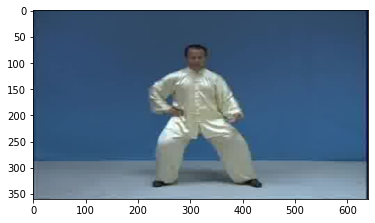

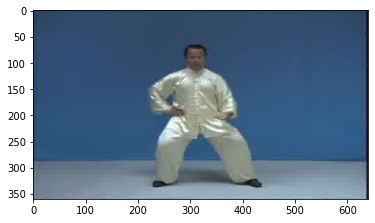

[[  8.823882   10.656532 ]
 [ 77.85383     8.59549  ]
 [151.97372     8.996703 ]
 [204.5238      5.7489867]
 [298.93234     8.186175 ]
 [349.7165      7.3493376]
 [428.9184      7.7355623]
 [494.66562     7.6661553]
 [563.05774     6.971601 ]
 [631.798       6.715865 ]
 [  7.3612328  45.542385 ]
 [ 75.60473    47.013096 ]
 [147.90614    39.832207 ]
 [212.98378    50.937363 ]
 [283.6621     44.581272 ]
 [351.70877    43.570496 ]
 [423.68982    46.960835 ]
 [499.29968    47.17912  ]
 [564.22845    47.325253 ]
 [632.85803    45.02726  ]
 [  7.802111   84.81293  ]
 [ 76.55239    88.103584 ]
 [149.03983    86.65724  ]
 [209.06203    83.56663  ]
 [284.6142     84.39173  ]
 [353.51767    84.80848  ]
 [420.2484     88.08077  ]
 [493.8245     84.55159  ]
 [561.99176    86.777214 ]
 [631.9944     83.525986 ]
 [  7.8726997 129.19739  ]
 [ 78.96464   125.03858  ]
 [144.63402   122.91215  ]
 [216.41418   123.837685 ]
 [284.8014    122.20972  ]
 [353.73386   122.15792  ]
 [421.83237   125.0448   ]
 

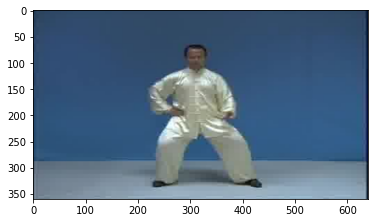

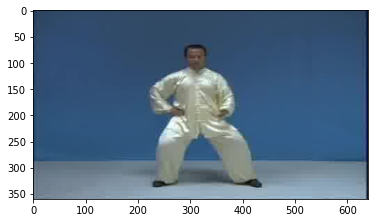

[[  7.8734617   7.6327877]
 [ 76.47252     8.016857 ]
 [147.16261     8.195654 ]
 [203.3392      6.904428 ]
 [288.426       8.09239  ]
 [354.75922     8.541275 ]
 [423.31845     8.056213 ]
 [494.71585     8.785892 ]
 [563.4818      7.547083 ]
 [631.586       7.922942 ]
 [  7.441474   47.28904  ]
 [ 77.39972    45.59303  ]
 [146.71262    46.07396  ]
 [206.59758    42.595192 ]
 [284.29675    46.134304 ]
 [354.79327    45.76646  ]
 [423.04953    46.05044  ]
 [493.12698    47.287495 ]
 [562.1105     45.74867  ]
 [632.06104    46.913155 ]
 [  8.150047   85.512215 ]
 [ 77.56402    84.98668  ]
 [149.46716    87.190475 ]
 [215.3253     82.79847  ]
 [284.59607    84.0604   ]
 [352.9874     83.085236 ]
 [423.48737    82.88397  ]
 [492.61108    87.21612  ]
 [561.8415     88.250275 ]
 [632.0516     87.2261   ]
 [  7.7337537 122.438774 ]
 [ 78.37792   122.43706  ]
 [148.89374   124.74067  ]
 [218.64883   123.387146 ]
 [285.28702   122.44989  ]
 [355.58038   121.98225  ]
 [425.1169    118.632126 ]
 

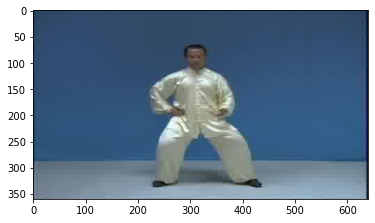

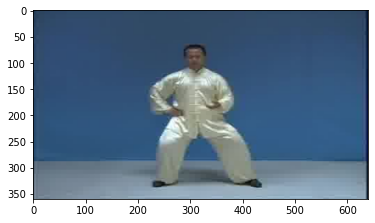

[[  8.537652    8.258971 ]
 [ 74.72606     8.384037 ]
 [149.6171      8.992957 ]
 [218.34        3.3593066]
 [282.81387     9.226589 ]
 [357.30838     5.1181755]
 [423.5429      8.989731 ]
 [491.54434     7.7944317]
 [562.23083     8.269929 ]
 [631.81305     7.087822 ]
 [  8.267409   46.49665  ]
 [ 77.61       47.31629  ]
 [158.9396     58.79998  ]
 [208.7632     38.581436 ]
 [283.25693    47.59257  ]
 [355.43204    45.444103 ]
 [424.32712    49.56921  ]
 [491.8522     44.9054   ]
 [559.9596     46.7578   ]
 [632.3596     45.072914 ]
 [  7.442999   98.67484  ]
 [ 78.31127    83.47053  ]
 [145.97945    82.9921   ]
 [215.82687    83.05743  ]
 [284.7817     83.2046   ]
 [352.10904    83.14296  ]
 [425.523      89.07497  ]
 [494.30487    85.673584 ]
 [562.4187     84.32591  ]
 [632.11127    84.32607  ]
 [  7.335062  122.93218  ]
 [ 77.22267   123.77273  ]
 [146.37471   122.99889  ]
 [216.18115   121.82822  ]
 [282.5179    122.72793  ]
 [351.71072   122.68207  ]
 [423.34637   121.832436 ]
 

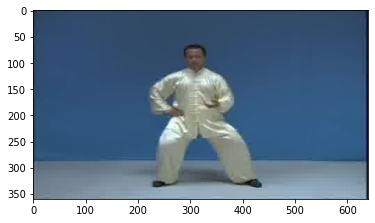

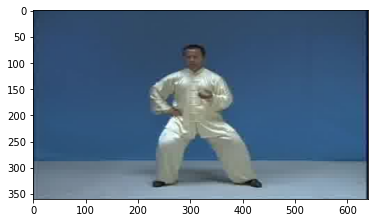

[[  8.918369    6.70002  ]
 [ 79.535065    8.411968 ]
 [134.39572     8.711345 ]
 [216.45976     7.755617 ]
 [283.8414      7.460224 ]
 [356.02423     8.506049 ]
 [426.25766     8.344086 ]
 [497.51102     8.952663 ]
 [558.1377      7.301115 ]
 [632.11633     6.7733397]
 [  7.795551   46.214676 ]
 [ 83.76465    46.51166  ]
 [147.9954     43.123196 ]
 [214.87094    43.89297  ]
 [287.72232    46.03885  ]
 [355.68793    44.678272 ]
 [422.57083    45.930645 ]
 [498.11966    46.253853 ]
 [561.95404    47.25971  ]
 [631.7586     48.94885  ]
 [  8.5552435  72.10227  ]
 [ 77.947655   86.13817  ]
 [144.34334    89.292984 ]
 [215.99089    78.32711  ]
 [284.20578    83.49914  ]
 [354.94092    84.52055  ]
 [427.05426    82.94189  ]
 [492.744      85.35539  ]
 [560.6927     83.895874 ]
 [631.58966    85.21593  ]
 [  7.7489862 123.43595  ]
 [ 77.75493   122.21307  ]
 [147.00844   125.74807  ]
 [218.02347   121.84816  ]
 [286.61865   125.34679  ]
 [351.2308    121.96888  ]
 [427.77814   115.291534 ]
 

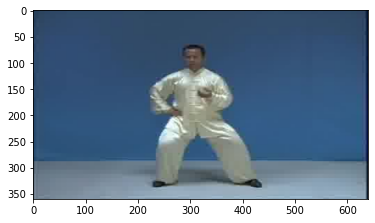

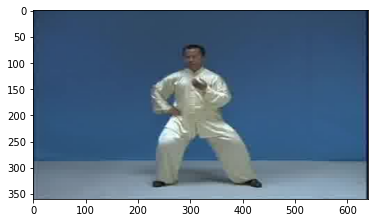

[[  6.415559    9.27412  ]
 [ 77.40423     7.9488673]
 [139.31024     7.29052  ]
 [204.56584     5.622179 ]
 [266.11926     7.849445 ]
 [350.68637     7.2572937]
 [424.96295     6.656421 ]
 [492.61182     8.879074 ]
 [562.8095      7.7988167]
 [631.41        8.182281 ]
 [  7.6990924  46.168198 ]
 [ 75.731674   47.39429  ]
 [158.6275     40.136738 ]
 [217.52638    41.63452  ]
 [285.24118    46.994343 ]
 [351.00214    45.866356 ]
 [434.81393    45.84562  ]
 [495.4073     48.184013 ]
 [561.3965     46.659016 ]
 [632.8673     45.866566 ]
 [  8.077105   84.3772   ]
 [ 70.57582    79.775375 ]
 [149.56396    76.21219  ]
 [226.67004    82.485405 ]
 [285.2477     84.664635 ]
 [350.3625     81.30521  ]
 [419.2526     86.346245 ]
 [493.26468    84.42157  ]
 [561.0047     86.82909  ]
 [632.1125     84.43732  ]
 [  7.827313  122.39471  ]
 [ 75.957985  128.05154  ]
 [151.54335   123.37481  ]
 [216.60506   126.60729  ]
 [284.19293   123.29168  ]
 [349.23953   120.607666 ]
 [425.50467   113.09751  ]
 

In [25]:
from numpy import load
np.set_printoptions(threshold=sys.maxsize)
data = load('Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM.npz', allow_pickle=True)
lst = data.files
for item in lst:
  for x in range(len(item)):
    plt.imshow(data[item][x][0])
    plt.show()
    plt.imshow(data[item][x][1])
    plt.show()
    print(data[item][x][2])

In [ ]:
# zip all numpy files
# cp NumPy zip file into drive